# BIA 6304 Predictive Models Fall 2017
## Final Project 
## UCern Questions
### Stuent:  Leonardo Ji
### 12/9/2017

### Import common library

In [964]:
import pandas as pd   #we almost always need pandas because we like data frames
import numpy as np
from bs4 import BeautifulSoup
import urllib3
import json
import math
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib import pyplot
import time
pd.set_option('display.max_colwidth', 150) #important for getting all the text
%matplotlib inline

### The Story
UCern is a social network site that allows collaboration between client support and development organizations.  There are many groups within UCern.  

Typically, support person would post a discussion thread as a question and an engineer would answer this question.  If the question is resolved then the discussion will be marked “Resolved” status.

We try to find a machine learning model to predict resolved status based on the data.

### Gather data
A python web scrapping is used to call UCern Content API to retrieve this data. The results are saved in a Panda .bin file to be read again.

In [ ]:
ucern = {}
#http://urllib3.readthedocs.io/en/latest/user-guide.html
http = urllib3.PoolManager()
headers = urllib3.util.make_headers(basic_auth='user:changeit')

url = 'https://connectupgradedev.ucern.com/api/core/v3/places/1356468/contents?sort=dateCreatedDesc&fields=%40all&filter=place%28https%3A//connectupgradedev.ucern.com/api/core/v3/places/1356468%29&abridged=false&count=100'
 
def loadContent(jsondata, ucern, count):
    for content in jsondata['list']:
        ucern[count] = {}
        ucern[count]['contentID'] = content['contentID'];
        if ('type' in content):
            ucern[count]['type'] = content['type']
        if ('subject' in content):
            ucern[count]['subject'] = content['subject']
        if ('viewCount' in content):
            ucern[count]['viewCount'] = content['viewCount']
        if ('replyCount' in content):
            ucern[count]['replyCount'] = content['replyCount']
        if ('lastActivityDate' in content):
            ucern[count]['lastActivityDate'] = content['lastActivityDate']
        if ('author' in content):
            ucern[count]['author'] = content['author']['displayName']
        if ('content' in content):
            # remove html tags using BeautifulSoup
            soup = BeautifulSoup(content['content']['text'], "lxml")
            ucern[count]['content'] = soup.get_text()
        if ('question' in content):
            ucern[count]['question'] = content['question']
            ucern[count]['resolved'] = False
            if ('resolved' in content and content['resolved'] == 'resolved'):
                ucern[count]['resolved'] = True
                if ('answer' in content):
                    ucern[count]['answerLink'] = content['answer']
                    req2 = http.request('GET', content['answer'], headers=headers)
                    json2 = json.loads(req2.data)
                    if ('content' in json2):
                        # remove html tags using BeautifulSoup
                        soup2 = BeautifulSoup(json2['content']['text'], "lxml")
                        ucern[count]['answer'] = soup2.get_text()
                        if ('author' in json2):
                            ucern[count]['answerAuthor'] = json2['author']['displayName']
        count = count + 1
    return count

i = 0
count = 0
while(url and i < 10):
    #print(url)
    req = http.request('GET', url, headers=headers)
    jsondata = json.loads(req.data)
    
    count = loadContent(jsondata, ucern, count)
    
    if (jsondata and jsondata['links'] and 'next' in jsondata['links']):
        url = jsondata['links']['next']
    i = i + 1
    
# convert data to panda dataframe
ucernDf = pd.DataFrame.from_dict(ucern,orient="index")

In [884]:
cd C:/Users/lj015625/Desktop/Predictive Model/Final Project

C:\Users\lj015625\Desktop\Predictive Model\Final Project


In [1039]:
# save data to disk
#ucernDf.to_pickle("ucernDf.bin")
ucernDf = pd.read_pickle("ucernDf_CM.bin")

In [1040]:
ucernDf.head()

,contentID,type,subject,viewCount,replyCount,lastActivityDate,author,content,question,resolved,answerLink,answer,answerAuthor
0,4124703,discussion,398 server running out of memory at intermountain,34,8,2017-05-18T16:59:53.867+0000,Sandeep Talluri,Issue: out of memory errors at intermountain attached heap dumps description: Care Management entry: 398 started: 17 May 2017 ...,True,True,https://connectcrt.ucern.com/api/core/v3/messages/4884699,What care management package is ihc_ut client is on? I reviewed the Java heap dump file. The 532.6MB out of 743MB of heap is used by loading UM w...,Leonardo Ji
1,4118973,discussion,interqual/mcg&#160; Content upgrade,9,0,2017-05-15T22:04:39.899+0000,Sandeep Talluri,I have a client who upgraded to Interqual 2017 a couple of weeks back and was down with this product for a week until he backed out and upgraded t...,True,False,NaN,NaN,NaN
2,4110891,discussion,3.6 Package Question,27,2,2017-05-12T14:27:37.615+0000,Larissa Lynn,I wanted to confirm if these are the proper packages for ACM 3.6: 97713 – Care Management 3.6 2015.0197716 – Mpages (US): Care Management 3.6 20...,False,False,NaN,NaN,NaN
3,4092330,discussion,FLHO_FL M1751 needs onboarded for Curaspan,22,2,2017-05-08T19:00:59.980+0000,Vinit Patel,Zip secure file is attached.,False,False,NaN,NaN,NaN
4,4091795,discussion,Internal server errors,22,1,2017-05-08T17:22:35.427+0000,Sandeep Talluri,I know this is unrelated and shouldn't cause any issues with Care Management but I have a client wanting to fix this error . Any advice ?Also I ju...,True,True,https://connectcrt.ucern.com/api/core/v3/messages/4854613,I have logged a Jira to fix this. [RCM-1609] Internal ear and external ear error - JIRA This is from websphere gladiator code cache error.,Leonardo Ji


In [1049]:
ucernDf.columns

Index(['index', 'contentID', 'type', 'subject', 'viewCount', 'replyCount',
       'lastActivityDate', 'author', 'content', 'question', 'resolved',
       'answerLink', 'answer', 'answerAuthor'],
      dtype='object')

In [1041]:
dtype_df = ucernDf.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,object,11


### Exploratory data analysis

(848, 13)

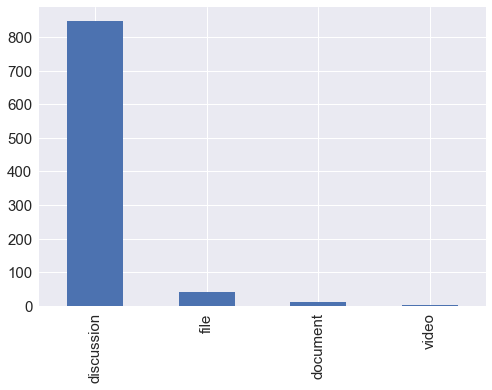

In [1042]:
ucernDf['type'].value_counts().plot(kind='bar')
ucernDf = ucernDf[(ucernDf['type'] == 'discussion')]
ucernDf.shape

In [1044]:
ucernDf['question'].value_counts()

True     627
False    221
Name: question, dtype: int64

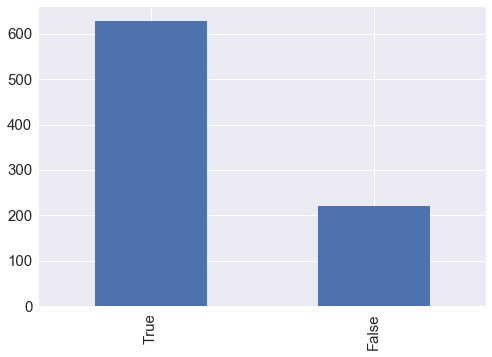

In [1045]:
# Lot of discussion but many are not marked as question
ucernDf['question'].value_counts().plot(kind='bar')

#### Resolved question
#### more target = 0 than target = 1.  We will look for models have higher Sensitivity and Precision ratios on target = 1.
$$Sensitivity  = \frac{True Positive}{True Positive + False Negative}$$
$$Precision = \frac{True Positive}{True Positive + False Positive}$$

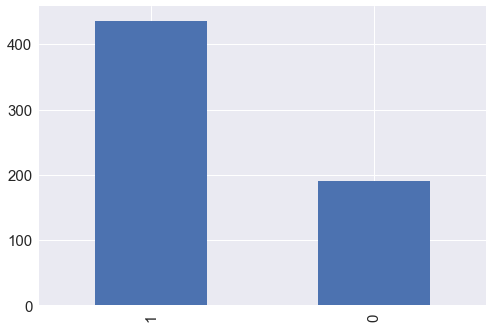

In [1046]:
ucernDf = ucernDf[(ucernDf['question'] == True)]
ucernDf['resolved'] = (ucernDf['resolved'] != False).astype(int)
ucernDf['resolved'].value_counts().plot(kind='bar')

In [1047]:
ucernDf = ucernDf.reset_index()
ucernDf.shape

(627, 14)

### Pre-processing to combine special terms, remove stop words.

In [796]:
# start preprocessing
# Preprocessing to replace words
my_dict = {'care management':'caremanagement', 'case management' : 'caremanagement', 'cm' : 'caremanagement', 
           'worklists':'worklist','carefinder pro':'carefinderpro','care finder pro':'carefinderpro', 'tlc':'ensocare',
           'um worklist': 'umWorklist','discharge worklist':'dischargeWorklist','assignment worklist':'assignmentWorklist',
           'clinical reviews':'clinicalreview','clinical review':'clinicalreview','errors' : 'error', 'visit information' : 'visitInformation',
           'insurance information':'insuranceInformation',
           'discharge planning':'dischargePlanning', 'post-acute':'postacute','post acute':'postacute','don\'t':'donot'}

def multiple_replace(dict, text): 
  """ Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new tring.""" 
  lowerText = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], lowerText)

ucernDf['cleancontent'] = ucernDf.content.apply(lambda x: multiple_replace(my_dict, x))
ucernDf['cleansubject'] = ucernDf.subject.apply(lambda x: multiple_replace(my_dict, x))
ucernDf['cleananswer'] = ucernDf.answer.apply(lambda x: multiple_replace(my_dict, x))

In [797]:
skl_stopwords = text.ENGLISH_STOP_WORDS
myStopwords = set(skl_stopwords)
print(len(myStopwords))
# Remove common exception stack trace tokens
myStopwords.update(set(['caremanagement','http','https','java','javax','com','cerner','service','enterprise','server','jdbc','internal','run','invoke',
                        'common','transaction','org','execute','client','reflect','sun','reflect','requesthandler','doprivileged','transactionmanager','container',
                        'lang','security','auth','native','method','subject','thread','accesscontroller','delegatingmethodaccessorimpl','interceptorchainimpl','servercontainer',
                        'cadence', 'intercept', 'caremanagementserver', 'util','unable','nativemethodaccessorimpl','servicemanager','rrservice', 'executors','spcinterceptor',
                        '00','01','10','11','12', '13', '14', '15', '16', '17', '53','91','160']))
print(len(myStopwords))

318
377


In [798]:
ps = PorterStemmer() #define method (http://www.nltk.org/api/nltk.stem.html#nltk.stem.porter.PorterStemmer)
ucernDf['cleancontent'] = [ps.stem(word) for word in ucernDf['cleancontent']] 
ucernDf['cleansubject'] = [ps.stem(word) for word in ucernDf['cleansubject']] 

### For resolved questions is there common words between questions
$$SharedWordsRatio  = \frac{NumberOfSharedWordsInQ1 + NumberOfSharedWordsInQ2}{Q1WordsLength + Q2WordsLength}$$

In [799]:
def word_match_share(question1, question2):
    q1words = {}
    q2words = {}
    for word in str(question1).lower().split():
        q1words[word] = 1
    for word in str(question2).lower().split():
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [800]:
question_shared_ratios = []

for index1, row1 in ucernDf.iterrows():
    q1 = row1['cleancontent']
    q1ID = row1['contentID']
    q1_resolved = row1['resolved']
    for index2, row2 in ucernDf.iterrows():
        q2 = row2['cleancontent']
        q2ID = row2['contentID']
        q2_resolved = row2['resolved']
        if q1 != q2:
            row = [q1ID, q1, q1_resolved, q2ID, q2, q2_resolved, word_match_share(q1, q2)]
            question_shared_ratios.append(row)

### Lots of question shared the same text.  The question with more shared words with other question then it is likely resolved.

In [801]:
cols = ["q1ContentID", "q1", "q1Resolved", "q2ContentID", "q2", "q2Resolved", "SharedWordsRatio"]                
question_shared_ratios = pd.DataFrame(question_shared_ratios, columns=cols)
question_shared_ratios = question_shared_ratios.sort_values('SharedWordsRatio')
question_shared_ratios.tail() 

,q1ContentID,q1,q1Resolved,q2ContentID,q2,q2Resolved,SharedWordsRatio
212490,1043251,"does anyone know what this error really means? and more importantly, how to fix it? somehow caremanagement is not communicating to oauth. note: ...",0,1165737,the following health checks were done for the caremanagement internal web server. verify that all checks passed with the expected results. failed ...,1,0.538071
99724,1927851,issue : secondary review request freezes and throws error.client : east_medomain : prod screen shot attached. 1) unable able to repoduce the issue...,1,1342677,"issue : when a user tries to assign multiple patients by left clicking several patients at one time, then click the assign me button, an error com...",1,0.553763
119725,1342677,"issue : when a user tries to assign multiple patients by left clicking several patients at one time, then click the assign me button, an error com...",1,1927851,issue : secondary review request freezes and throws error.client : east_medomain : prod screen shot attached. 1) unable able to repoduce the issue...,1,0.553763
72166,2209551,sr#410110371client: ihc_utdomain: prodcodelevel: 3.1 stp issue: error opening jata in bedrock !entry com.cerner.bedrock.internal.application.util....,1,1635216,ashw_ca prodissue: issue opening jata wizard exception: current error 12/9/14 8:36 am:java.lang.runtimeexception: java.lang.reflect.invocation...,1,0.559036
110917,1635216,ashw_ca prodissue: issue opening jata wizard exception: current error 12/9/14 8:36 am:java.lang.runtimeexception: java.lang.reflect.invocation...,1,2209551,sr#410110371client: ihc_utdomain: prodcodelevel: 3.1 stp issue: error opening jata in bedrock !entry com.cerner.bedrock.internal.application.util....,1,0.559036


In [802]:
maxSharedWordsRatio = []
sumSharedWordsRatio = []
for index, row in ucernDf.iterrows():
    id = row['contentID']
    # get max shared words ratio with other resolved questions 
    allq1 = question_shared_ratios[(question_shared_ratios.q1ContentID == id)]
    maxRatio = allq1['SharedWordsRatio'].max()
    maxSharedWordsRatio.append(maxRatio)

In [803]:
ucernDf['MaxSharedWordsRatio'] = maxSharedWordsRatio
ucernDf['MaxSharedWordsRatio'].fillna(0, inplace=True) 

### Convert text to Document Matrix

Document frequency df(j) shows the number of document containing word j. Inverse document frequency idf(j) reverses scale by applying logarithmically scale on it. If word j is in many documents then it is less important, if word j appears in a few documents then it is unique and more important.
$$idf(j) = log(\frac{N}{df(j)})$$


Term frequency tf(j) of term j is the raw count of term j in the document. The term frequency inverse-document-frequency tf_idf weighting is calculated by multiply tf(j) and idf(j).
$$tf\_idf(j) = tf(j) ∗ idf(j)$$

In [804]:
# tf-idf on content
tfidf = TfidfVectorizer(use_idf=True, norm=None, 
                         stop_words = myStopwords, 
                         min_df = 0.06, 
                         max_df = 0.90, 
                         ngram_range = (1,3)) #define the transformation
tfidf_dm = tfidf.fit_transform(ucernDf['cleancontent']) #apply the transformation
print(tfidf_dm.shape)

tfidf_content_df = pd.DataFrame(tfidf_dm.toarray(), columns = tfidf.get_feature_names())
tfidf_content_df.head()

(627, 142)


,22,398,43,able,access,add,advice,ahs_fl,application,attached,...,user,users,using,version,work,worker,workflow,working,worklist,works
0,0.0,5.46602,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.300877,...,2.515286,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,3.399489,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,3.223032,0.000000,3.571339,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,6.982593,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.000000,6.798978,3.571339,0.0,0.0,0.000000,...,0.000000,0.0,10.360668,0.000000,6.475695,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [806]:
# tf-idf on subject, because subject is smaller text so set minimual df to 2%
tfidf_sub = TfidfVectorizer(use_idf=True, norm=None, 
                         stop_words = myStopwords, 
                         min_df = 0.02, 
                         max_df = 0.90, 
                         ngram_range = (1,3)) #define the transformation
tfidf_sub_dm = tfidf_sub.fit_transform(ucernDf['cleansubject']) #apply the transformation
print(tfidf_sub_dm.shape)

tfidf_sub_df = pd.DataFrame(tfidf_sub_dm.toarray(), columns = tfidf_sub.get_feature_names())
tfidf_sub_df.columns = [str(col) + '_sub' for col in tfidf_sub_df.columns]
tfidf_sub_df.head()

(627, 41)


,bedrock_sub,carefinderpro_sub,clinicalreview_sub,compon_sub,component_sub,days_sub,discharge_sub,dischargeplanning_sub,dischargeworklist_sub,does_sub,...,script_sub,services_sub,showing_sub,sr_sub,status_sub,summary_sub,um_sub,umworklist_sub,working_sub,worklist_sub
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.0,0.0,0.0,4.146703,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.73449,0.0


### Predicting Resolved status from tfid-idf generated from question body text, reply count, view count, questioner name, shared words ratio.

In [1000]:
Xdf = pd.concat([tfidf_content_df, tfidf_sub_df], axis=1)
Xdf['replyCount'] = np.transpose(ucernDf.replyCount.values)
Xdf['viewCount'] = np.transpose(ucernDf.viewCount.values)
# convert author to code
ucernDf['authorCode'] = ucernDf['author'].astype('category').cat.codes
Xdf['authorCode'] = np.transpose(ucernDf.authorCode.values)
# shared words ratios
Xdf['MaxSharedWordsRatio'] = np.transpose(ucernDf.MaxSharedWordsRatio)
Xdf.head()

,22,398,43,able,access,add,advice,ahs_fl,application,attached,...,status_sub,summary_sub,um_sub,umworklist_sub,working_sub,worklist_sub,replyCount,viewCount,authorCode,MaxSharedWordsRatio
0,0.0,5.46602,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.300877,...,0.0,0.0,0.0,0.0,0.00000,0.0,8,34,31,0.428571
1,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,0,9,31,0.309091
2,0.0,0.00000,0.0,0.0,3.223032,0.000000,3.571339,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,1,22,31,0.400000
3,0.0,0.00000,0.0,0.0,0.000000,6.798978,3.571339,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00000,0.0,1,32,31,0.276364
4,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,4.73449,0.0,1,35,31,0.251163


#### Collinearity analysis on all features

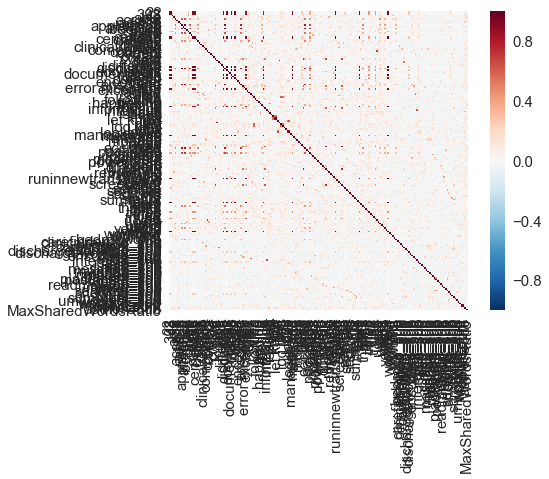

In [1020]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
sns.set(font_scale=1.5)
hm = sns.heatmap(Xdf.corr(), 
            cbar=True,
            annot=False,
            square=True,
            fmt='.2f')
plt.show()

In [1001]:
X = Xdf  #remember this is the output from the vectorizer and we are turning it into an array
y = ucernDf.resolved.values #this is an array of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(438, 187)
(189, 187)
(438,)
(189,)


### Run Logistic Regression Model using train/test 

In [841]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
clf_lg = LogisticRegression()
print(clf_lg)
clf_lg.fit(X_train, y_train)

# make predictions
clf_lg_expected = y_test
clf_lg_predicted = clf_lg.predict(X_test)

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_lg_expected, clf_lg_predicted)))
print(metrics.classification_report(clf_lg_expected, clf_lg_predicted))
print(confusion_matrix(clf_lg_expected, clf_lg_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy: 0.582010582011
             precision    recall  f1-score   support

          0       0.31      0.32      0.31        57
          1       0.70      0.70      0.70       132

avg / total       0.58      0.58      0.58       189

[[18 39]
 [40 92]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 19.7 percentage from its mean the model is overfitting.

In [842]:
scores = cross_val_score(clf_lg, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.51111111  0.4         0.55555556  0.57777778  0.51162791  0.51162791
  0.74418605  0.53488372  0.6744186   0.44186047]
Cross Validation Score mean:  0.546304909561
Cross Validation Max and Min Score difference from mean score:  0.146304909561 0.197881136951


### Run KNN Model using train/test 

In [843]:
# KNN
# creating odd list of K for KNN
myList = list(range(1,35))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

#takes some time, get a soda...
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 25


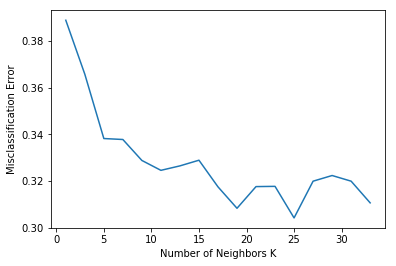

In [844]:
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [845]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 25)
clf_knn = KNeighborsClassifier(n_neighbors=25, p = 1)
clf_knn.fit(X_train, y_train)
print(clf_knn)

# make predictions
knn_expected = y_test
knn_predicted = clf_knn.predict(X_test)
print(clf_knn.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn_expected, knn_predicted)))
print(metrics.classification_report(knn_expected, knn_predicted))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=1,
           weights='uniform')
0.698412698413
accuracy: 0.698412698413
             precision    recall  f1-score   support

          0       0.50      0.02      0.03        57
          1       0.70      0.99      0.82       132

avg / total       0.64      0.70      0.58       189



#### Verify with 10-fold Cross Validation
All 10-folds results within 5.9 percentage from mean and this means the model does overfit.

In [846]:
scores = cross_val_score(clf_knn, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.68888889  0.75555556  0.66666667  0.68888889  0.72093023  0.69767442
  0.6744186   0.72093023  0.65116279  0.69767442]
Cross Validation Score mean:  0.696279069767
Cross Validation Max and Min Score difference from mean score:  0.0451162790698 0.0592764857881


### Run Decision Tree Model using train/test
Decision Tree Model will be the base line model

In [847]:
#Decision Tree train model. Call up my model and name it clf
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf = 4, min_samples_split = 5)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_dt)
#Fit clf to the training data
clf_dt = clf_dt.fit(X_train, y_train)


# make predictions
dt_expected = y_test
dt_predicted = clf_dt.predict(X_test)
print(clf_dt.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.608465608466
accuracy: 0.608465608466
             precision    recall  f1-score   support

          0       0.38      0.49      0.43        57
          1       0.75      0.66      0.70       132

avg / total       0.64      0.61      0.62       189



##### Verify with 10-fold Cross Validation
All 10-folds results within 10.9 percentage from mean and this means the model is overfitting.

In [848]:
scores = cross_val_score(clf_dt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.6         0.64444444  0.64444444  0.57777778  0.53488372  0.65116279
  0.74418605  0.65116279  0.69767442  0.60465116]
Cross Validation Score mean:  0.63503875969
Cross Validation Max and Min Score difference from mean score:  0.10015503876 0.109147286822


### Run Random Forest Model using train/test

In [887]:
start_time = time.clock()
rfc = RandomForestClassifier() 
param_grid = { 
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print("SCORES", CV_rfc.cv_results_)
print("BEST SCORE", CV_rfc.best_score_)
print("BEST PARAM", CV_rfc.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.11881185,  0.25902591,  0.60266032,  1.15491548,  0.13621354,
        0.25262532,  0.59805965,  1.21032104,  0.11421132,  0.23522344,
        0.61686168,  1.19651961,  0.11161118,  0.22302237,  0.55685558,
        1.12751269,  0.11361141,  0.2368238 ,  0.55525546,  1.14751468,
        0.11701174,  0.22342238,  0.5726573 ,  1.17851791,  0.11681166,
        0.21862178,  0.55765576,  1.11051102,  0.11081109,  0.21842189,
        0.55565572,  1.09510946,  0.10941091,  0.21782184,  0.54065404,
        1.13891382,  0.11441135,  0.2258224 ,  0.57765779,  1.13064771,
        0.12279997,  0.22719998,  0.56579995,  1.14100008,  0.11379995,
        0.2276    ,  0.56460004,  1.12579999,  0.11339993,  0.22099996,
        0.55180001,  1.10120001,  0.11200004,  0.22179999,  0.5552    ,
        1.1132    ,  0.11139998,  0.22119999,  0.55020008,  1.10219998,
        0.10899997,  0.21580005,  0.54039989,  1.08639994,  0.10920014,
        0.21620002,  0.54560008,  1.078

In [885]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 4, min_samples_split = 4, 
                                n_estimators=1000)
clf_rf.fit(X_train, y_train)

clf_rf_expected = y_test
clf_rf_predicted = clf_rf.predict(X_test)
print(clf_rf.score(X_test, y_test))
#print(clf_rf.feature_importances_)

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_rf_expected, clf_rf_predicted)))
print(metrics.classification_report(clf_rf_expected, clf_rf_predicted))
print(confusion_matrix(clf_rf_expected, clf_rf_predicted))

0.698412698413
accuracy: 0.698412698413
             precision    recall  f1-score   support

          0       0.50      0.07      0.12        57
          1       0.71      0.97      0.82       132

avg / total       0.64      0.70      0.61       189

[[  4  53]
 [  4 128]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 3.4 percentage from its mean the model is not overfitting.

In [886]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.73333333  0.71111111  0.68888889  0.68888889  0.72093023  0.69767442
  0.69767442  0.69767442  0.72093023  0.74418605]
Cross Validation Score mean:  0.710129198966
Cross Validation Max and Min Score difference from mean score:  0.0212403100775 0.0340568475452


### Run SVM Model using train/test 

#### Grid Search

In [852]:
start_time = time.clock()
from sklearn.svm import SVC
parameters = {'C':[0.0005, 0.001, 0.005],
              'kernel': ['linear'],
              'gamma': ['auto']}
svr = SVC()
grid_svm = GridSearchCV(svr, parameters,n_jobs=-1, cv=5)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.02240224,  0.02400241,  0.03880391]), 'std_fit_time': array([ 0.0010198 ,  0.00303348,  0.0105726 ]), 'mean_score_time': array([ 0.00400038,  0.01080098,  0.00400043]), 'std_score_time': array([  1.78416128e-07,   1.26250947e-02,   6.32409692e-04]), 'param_C': masked_array(data = [0.0005 0.001 0.005],
             mask = [False False False],
       fill_value = ?)
, 'param_gamma': masked_array(data = ['auto' 'auto' 'auto'],
             mask = [False False False],
       fill_value = ?)
, 'param_kernel': masked_array(data = ['linear' 'linear' 'linear'],
             mask = [False False False],
       fill_value = ?)
, 'params': [{'C': 0.0005, 'gamma': 'auto', 'kernel': 'linear'}, {'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}, {'C': 0.005, 'gamma': 'auto', 'kernel': 'linear'}], 'split0_test_score': array([ 0.69318182,  0.69318182,  0.625     ]), 'split1_test_score': array([ 0.69318182,  0.69318182,  0.68181818]), 'split2_test_score': array([ 0.6931

#### Linear SVM Model with Grid Search found Penalty Cost

In [853]:
from sklearn.svm import SVC
start_time = time.clock()
#standard linear SVC
clf_SVC = SVC(kernel='linear', C=0.001, gamma='auto')
clf_SVC.fit(X_train, y_train)
predicted_SVC=clf_SVC.predict(X_test)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 0.042690107991802506 seconds


In [854]:
# summarize the fit of the model
clf_SVC_expected = y_test
print(classification_report(clf_SVC_expected, predicted_SVC, target_names=['0', '1']))
print(confusion_matrix(clf_SVC_expected, predicted_SVC))
print(accuracy_score(clf_SVC_expected, predicted_SVC))

             precision    recall  f1-score   support

          0       1.00      0.02      0.03        57
          1       0.70      1.00      0.82       132

avg / total       0.79      0.70      0.59       189

[[  1  56]
 [  0 132]]
0.703703703704


#### Verify with 10-fold Cross Validation
All 10-folds results within 4.5% from mean and this means the model is not overfitting.

In [855]:
scores = cross_val_score(clf_SVC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.68888889  0.68888889  0.68888889  0.64444444  0.69767442  0.69767442
  0.69767442  0.69767442  0.69767442  0.69767442]
Cross Validation Score mean:  0.689715762274
Cross Validation Max and Min Score difference from mean score:  0.0452713178295 0.00795865633075


### Run Bagging Model using train/test 
Bootstrap sampling creates many random samples with replacement and combine output with voting. This reduced variance of a single learner.

#### Grid Search

In [856]:
from sklearn.ensemble import BaggingClassifier
start_time = time.clock()
clf_bag = BaggingClassifier()
parameters = {'n_estimators':[100, 300, 500], 'max_features':[30,40,50]}
grid_svm = GridSearchCV(clf_bag, parameters, n_jobs=-1, cv=5)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.15221539,  0.66986699,  1.35013494,  0.31763177,  0.96209626,
        1.61636181,  0.35343537,  1.0581059 ,  1.37833781]), 'std_fit_time': array([ 0.00097988,  0.17907923,  0.05407561,  0.00300702,  0.03225228,
        0.03522508,  0.00463077,  0.00814943,  0.13408113]), 'mean_score_time': array([ 0.00720062,  0.03000288,  0.05780587,  0.01280127,  0.03600359,
        0.06100607,  0.01260128,  0.03560357,  0.04200425]), 'std_score_time': array([ 0.00040011,  0.00712815,  0.00116632,  0.00074848,  0.00063256,
        0.00167346,  0.00080014,  0.00049002,  0.00864957]), 'param_max_features': masked_array(data = [30 30 30 40 40 40 50 50 50],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_n_estimators': masked_array(data = [100 300 500 100 300 500 100 300 500],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'params': [{'max_features': 30, '

In [888]:
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier(n_estimators=300, max_features=40)
clf_bag.fit(X_train, y_train)

clf_bag_expected = y_test
clf_bag_predicted = clf_bag.predict(X_test)
print(accuracy_score(clf_bag_expected, clf_bag_predicted))

print(classification_report(clf_bag_expected, clf_bag_predicted, target_names=['0', '1']))
print(confusion_matrix(clf_bag_expected, clf_bag_predicted))

0.693121693122
             precision    recall  f1-score   support

          0       0.43      0.05      0.09        57
          1       0.70      0.97      0.82       132

avg / total       0.62      0.69      0.60       189

[[  3  54]
 [  4 128]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 3.8 percentage from mean and this means the model is not overfitting.

In [889]:
scores = cross_val_score(clf_bag, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.71111111  0.71111111  0.71111111  0.71111111  0.72093023  0.76744186
  0.69767442  0.74418605  0.74418605  0.76744186]
Cross Validation Score mean:  0.728630490956
Cross Validation Max and Min Score difference from mean score:  0.0309560723514 0.038811369509


### Run Naive Bayes Model using train/test 

In [859]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# fit a Naive Bayes model to the data
clf_nb = GaussianNB()
print(clf_nb)
clf_nb.fit(X_train, y_train)

# make predictions
clf_nb_expected = y_test
clf_nb_predicted = clf_nb.predict(X_test)

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf_nb_expected, clf_nb_predicted)))
print(metrics.classification_report(clf_nb_expected, clf_nb_predicted))
print(confusion_matrix(clf_nb_expected, clf_nb_predicted))

GaussianNB(priors=None)
accuracy: 0.597883597884
             precision    recall  f1-score   support

          0       0.19      0.11      0.14        57
          1       0.68      0.81      0.74       132

avg / total       0.53      0.60      0.56       189

[[  6  51]
 [ 25 107]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 14.6 percentage from mean and this means the model is overfitting.

In [860]:
scores = cross_val_score(clf_nb, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.6         0.6         0.68888889  0.55555556  0.65116279  0.72093023
  0.55813953  0.6744186   0.46511628  0.60465116]
Cross Validation Score mean:  0.61188630491
Cross Validation Max and Min Score difference from mean score:  0.14677002584 0.109043927649


### Run AdaBoosting Model using train/test 
We can use Boosting on Naive Bayes to reduce overfitting.  Boosting reweights training data that previous learner did not do well, and can produce good result from many unstable learners. 

#### Grid Search

In [932]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

start_time = time.clock()
clf_boost = AdaBoostClassifier(base_estimator=MultinomialNB(), algorithm="SAMME")

parameters = {'n_estimators':[700, 850, 1000],
              'learning_rate':[0.003, 0.005, 0.007]}
grid_boost = GridSearchCV(clf_boost, parameters, n_jobs=-1, cv=5)
grid_boost.fit(X_train, y_train)
print("SCORES", grid_boost.cv_results_)
print("BEST SCORE", grid_boost.best_score_)
print("BEST PARAM", grid_boost.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.86160002,  3.16499996,  8.56620007,  1.28439999,  1.64139986,
        3.64999995,  2.7894001 ,  3.99959998,  2.25439997]), 'std_fit_time': array([ 0.05247713,  3.64563806,  3.38757135,  0.04737341,  0.08012888,
        3.43624422,  1.88667804,  3.28242282,  0.98712834]), 'mean_score_time': array([ 0.05459995,  0.40799999,  1.46499996,  0.25339999,  0.39400005,
        1.51660004,  0.78719997,  0.3836    ,  0.12379994]), 'std_score_time': array([ 0.01040389,  0.60883757,  0.66483829,  0.20806211,  0.27237543,
        2.02120488,  0.95534553,  0.33814882,  0.04047914]), 'param_learning_rate': masked_array(data = [0.003 0.003 0.003 0.005 0.005 0.005 0.007 0.007 0.007],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_n_estimators': masked_array(data = [700 850 1000 700 850 1000 700 850 1000],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'p

In [940]:
clf_boost = AdaBoostClassifier(base_estimator=MultinomialNB(),
                         algorithm="SAMME",      
                         n_estimators=700, 
                         learning_rate=0.003)

clf_boost.fit(X_train, y_train)

clf_boost_expected = y_test
clf_boost_predicted = clf_boost.predict(X_test)

print(accuracy_score(clf_boost_expected, clf_boost_predicted))
print(classification_report(clf_boost_expected, clf_boost_predicted, target_names=['0', '1']))
print(confusion_matrix(clf_boost_expected, clf_boost_predicted))

0.68253968254
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.69      0.98      0.81       132

avg / total       0.48      0.68      0.57       189

[[  0  57]
 [  3 129]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 3.5% from mean and this means the model does not overfit.

In [941]:
scores = cross_val_score(clf_boost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.68888889  0.68888889  0.64444444  0.68888889  0.69767442  0.69767442
  0.6744186   0.6744186   0.69767442  0.65116279]
Cross Validation Score mean:  0.680413436693
Cross Validation Max and Min Score difference from mean score:  0.0359689922481 0.0172609819121


### Run Extra Tree Model using train/test 

#### Grid  Search

In [864]:
from sklearn.ensemble import ExtraTreesClassifier
start_time = time.clock()
clf_xdt = ExtraTreesClassifier()
param_grid = { 
    'n_estimators': [100, 300, 500],
    'max_depth': [50, 100, 200],
    'min_samples_leaf': [4],
    'min_samples_split' : [5]
}
clf_xdt = GridSearchCV(estimator=clf_xdt, param_grid=param_grid, cv= 5)
clf_xdt.fit(X_train, y_train)
print("SCORES", clf_xdt.cv_results_)
print("BEST SCORE", clf_xdt.best_score_)
print("BEST PARAM", clf_xdt.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.1150115 ,  0.329633  ,  0.54965491,  0.11081109,  0.3296329 ,
        0.54765472,  0.11101117,  0.32923293,  0.54765482]), 'std_fit_time': array([ 0.00802579,  0.00185488,  0.00372066,  0.00097973,  0.00149682,
        0.00307276,  0.00126505,  0.00116626,  0.00382663]), 'mean_score_time': array([ 0.00600066,  0.01740184,  0.02820282,  0.00600057,  0.01720166,
        0.02780275,  0.00600057,  0.01660166,  0.02780271]), 'std_score_time': array([  1.16800773e-07,   4.90057117e-04,   4.00042545e-04,
         1.78416128e-07,   3.99947177e-04,   3.99971008e-04,
         9.53674316e-08,   4.89862488e-04,   4.00066376e-04]), 'param_max_depth': masked_array(data = [50 50 50 100 100 100 200 200 200],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_min_samples_leaf': masked_array(data = [4 4 4 4 4 4 4 4 4],
             mask = [False False False False False False False False False],
       fill_value

#### Grid Search 2

In [865]:
from sklearn.ensemble import ExtraTreesClassifier
start_time = time.clock()
clf_xdt = ExtraTreesClassifier()
param_grid = { 
    'n_estimators': [100],
    'max_depth': [50],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split' : [5, 10],
    'criterion' : ['gini','entropy']
}
clf_xdt = GridSearchCV(estimator=clf_xdt, param_grid=param_grid, cv= 5)
clf_xdt.fit(X_train, y_train)
print("SCORES", clf_xdt.cv_results_)
print("BEST SCORE", clf_xdt.best_score_)
print("BEST PARAM", clf_xdt.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 0.11741161,  0.11101108,  0.10741076,  0.10801077,  0.10441041,
        0.10401044,  0.11361141,  0.1138113 ,  0.10961089,  0.10981097,
        0.10541039,  0.10541034]), 'std_fit_time': array([ 0.00906951,  0.00154954,  0.00101989,  0.00109567,  0.00048998,
        0.00089452,  0.00120006,  0.00146978,  0.00135665,  0.00172057,
        0.00101991,  0.00120012]), 'mean_score_time': array([ 0.00700073,  0.00600057,  0.00720067,  0.00600061,  0.00580058,
        0.00600052,  0.00600047,  0.0062007 ,  0.00560055,  0.00580063,
        0.0056006 ,  0.00600076]), 'std_score_time': array([  2.00018883e-03,   1.78416128e-07,   1.93930027e-03,
         6.32409703e-04,   4.00114074e-04,   1.50789149e-07,
         9.53674316e-08,   4.00114074e-04,   4.90057117e-04,
         4.00137912e-04,   4.89901382e-04,   0.00000000e+00]), 'param_criterion': masked_array(data = ['gini' 'gini' 'gini' 'gini' 'gini' 'gini' 'entropy' 'entropy' 'entropy'
 'entropy' 'entropy' 'entro

In [866]:
clf_xdt = ExtraTreesClassifier(criterion = 'gini', max_depth=50,
                               n_estimators=100, 
                               min_samples_split=10, 
                               min_samples_leaf=5)
clf_xdt.fit(X_train,y_train)

clf_xdt_expected = y_test
clf_xdt_predicted = clf_xdt.predict(X_test)

print("Extra Trees", accuracy_score(clf_xdt_expected, clf_xdt_predicted))
print(classification_report(clf_xdt_expected, clf_xdt_predicted,target_names=['0', '1']))
print(confusion_matrix(clf_xdt_expected, clf_xdt_predicted))

Extra Trees 0.693121693122
             precision    recall  f1-score   support

          0       0.40      0.04      0.06        57
          1       0.70      0.98      0.82       132

avg / total       0.61      0.69      0.59       189

[[  2  55]
 [  3 129]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 4.5% from mean and this means the model is not overfitting.

In [867]:
scores = cross_val_score(clf_xdt, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.71111111  0.68888889  0.68888889  0.68888889  0.69767442  0.69767442
  0.69767442  0.6744186   0.69767442  0.74418605]
Cross Validation Score mean:  0.698708010336
Cross Validation Max and Min Score difference from mean score:  0.0242894056848 0.0454780361757


### Run Gradient Boosting Model using train/test 

#### Grid Search

In [868]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.clock()
clf_gbc = GradientBoostingClassifier()
parameters = {'n_estimators': [1000], 'learning_rate':[0.06, 0.07, 0.08], 'max_depth':[4,5,6,7]}
grid_svm = GridSearchCV(clf_gbc, parameters, n_jobs=-1, cv=5)
grid_svm.fit(X_train, y_train)
print("SCORES", grid_svm.cv_results_)
print("BEST SCORE", grid_svm.best_score_)
print("BEST PARAM", grid_svm.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

SCORES {'mean_fit_time': array([ 2.01160131,  3.98359833,  4.2956295 ,  4.14941483,  3.46214614,
        4.06300626,  3.7927793 ,  4.23722367,  3.48634868,  3.55915589,
        3.33253331,  2.78687873]), 'std_fit_time': array([ 0.030803  ,  0.62769582,  0.121834  ,  0.12762624,  0.02715714,
        0.13325676,  0.09416803,  0.70794974,  0.0838224 ,  0.03880278,
        0.13294702,  0.12226868]), 'mean_score_time': array([ 0.00240016,  0.00400038,  0.00380039,  0.00360036,  0.00360041,
        0.00360041,  0.00380034,  0.00380044,  0.00400043,  0.00340028,
        0.00340028,  0.00260024]), 'std_score_time': array([  4.89979242e-04,   1.78416128e-07,   4.00066404e-04,
         4.89979265e-04,   4.90115523e-04,   4.90018230e-04,
         4.00042545e-04,   4.00090257e-04,   2.13248060e-07,
         4.89920847e-04,   4.89823515e-04,   7.99977784e-04]), 'param_learning_rate': masked_array(data = [0.06 0.06 0.06 0.06 0.07 0.07 0.07 0.07 0.08 0.08 0.08 0.08],
             mask = [False False 

In [869]:
clf_GBC = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.07, max_depth = 4)
clf_GBC.fit(X_train, y_train)

expected_GBC = y_test
predicted_GBC=clf_GBC.predict(X_test)

print("Gradient Boost Accuracy", accuracy_score(expected_GBC,predicted_GBC))
print(classification_report(expected_GBC, predicted_GBC,target_names=['0', '1']))
print(confusion_matrix(expected_GBC, predicted_GBC))

Gradient Boost Accuracy 0.677248677249
             precision    recall  f1-score   support

          0       0.44      0.28      0.34        57
          1       0.73      0.85      0.79       132

avg / total       0.65      0.68      0.65       189

[[ 16  41]
 [ 20 112]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 4.5% from mean and this means the model is not overfitting.

In [870]:
scores = cross_val_score(clf_GBC, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.73333333  0.68888889  0.73333333  0.66666667  0.6744186   0.74418605
  0.74418605  0.72093023  0.72093023  0.69767442]
Cross Validation Score mean:  0.712454780362
Cross Validation Max and Min Score difference from mean score:  0.0457881136951 0.0317312661499


### Extreme Gradient Boosting
XGBoost is a very popular algorithm on *Kaggle*. 
* http://xgboost.readthedocs.io/en/latest/python/python_api.html
* https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

Avoid XGBoost overfitting:
* https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

#### Grid Search
XGBoost Grid Search example https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

In [ ]:
from xgboost import XGBClassifier

start_time = time.clock()
clf_xgb = XGBClassifier()

parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.06, 0.07], #so called `eta` value
              'max_depth': [4,5,6],
              'min_child_weight': [10, 11, 12],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'seed': [1337]}

grid_xgboost = GridSearchCV(clf_xgb, parameters, n_jobs=-1, cv=10)
grid_xgboost.fit(X_train, y_train)
print("SCORES", grid_xgboost.cv_results_)
print("BEST SCORE", grid_xgboost.best_score_)
print("BEST PARAM", grid_xgboost.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

In [ ]:
from xgboost import XGBClassifier

start_time = time.clock()
clf_xgb = XGBClassifier()

parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.07,0.08,0.09], #so called `eta` value
              'max_depth': [3,4],
              'min_child_weight': [12,13,14],
              'subsample': [0.6,0.7,0.8],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'n_estimators': [800,900,1000,1100,1200], #number of trees, change it to 1000 for better results
              'seed': [1337]}

grid_xgboost = GridSearchCV(clf_xgb, parameters, n_jobs=-1, cv=10)
grid_xgboost.fit(X_train, y_train)
print("SCORES", grid_xgboost.cv_results_)
print("BEST SCORE", grid_xgboost.best_score_)
print("BEST PARAM", grid_xgboost.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

In [1027]:
clf_xgboost = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.08, 
    max_depth = 3,
    min_child_weight=14,
    n_estimators=900,
    objective="binary:logistic",
    subsample = 0.6,
    seed = 1337               
   )
eval_set = [(X_train, y_train), (X_test, y_test)]
clf_xgboost = clf_xgboost.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

y_pred = clf_xgboost.predict(X_test)
predictions = [round(value) for value in y_pred]

In [1028]:
expected_xgboost = y_test
predicted_xgboost= clf_xgboost.predict(X_test)
print("Accuracy", accuracy_score(expected_xgboost, predicted_xgboost))
print(classification_report(expected_xgboost, predicted_xgboost,target_names=['0', '1']))
print(confusion_matrix(expected_xgboost, predicted_xgboost))

Accuracy 0.62962962963
             precision    recall  f1-score   support

          0       0.29      0.16      0.20        57
          1       0.70      0.83      0.76       132

avg / total       0.57      0.63      0.59       189

[[  9  48]
 [ 22 110]]


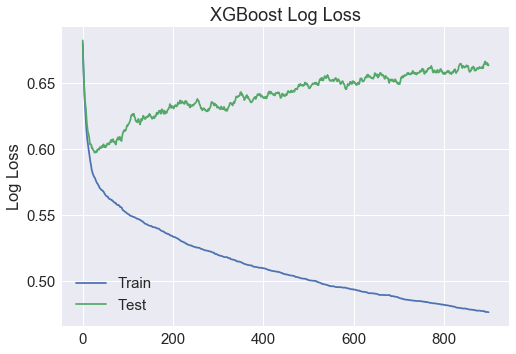

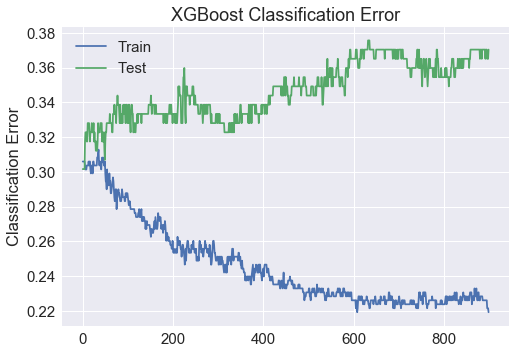

In [1029]:
predictions = [round(value) for value in predicted_xgboost]
# retrieve performance metrics
results = clf_xgboost.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

#### Select a early stopping rounds = 50 based on classification error

In [1036]:
clf_xgboost = XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.06, 
    max_depth = 3,
    min_child_weight=11,
    n_estimators=1000,
    objective="binary:logistic",
    subsample = 0.6,
    seed = 1337               
   )

eval_set = [(X_train, y_train), (X_test, y_test)]
clf_xgboost = clf_xgboost.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, early_stopping_rounds=50, verbose=False)

y_pred = clf_xgboost.predict(X_test)

#### Verify with 10-fold Cross Validation
All 10-folds results within 9.1% from mean and this means the model is overfitting.

In [1037]:
scores = cross_val_score(clf_xgboost, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.75555556  0.75555556  0.68888889  0.71111111  0.72093023  0.72093023
  0.72093023  0.6744186   0.60465116  0.60465116]
Cross Validation Score mean:  0.695762273902
Cross Validation Max and Min Score difference from mean score:  0.0911111111111 0.0597932816537


### Run Multi-layer Perceptron Model using train/test  

#### Grid Search

In [906]:
from sklearn.neural_network import MLPClassifier
start_time = time.clock()
parameters={
    'alpha':[1e-05], 'batch_size':['auto'], 'beta_1':[0.9], 'beta_2':[0.999], 'early_stopping':[False],'epsilon':[1e-08],
    'learning_rate':['constant'],'learning_rate_init':[0.001],'momentum':[0.9],'learning_rate_init':[True],'power_t':[0.5],
    'random_state':[47],'shuffle':[True],'solver':['lbfgs'],'tol':[0.0001],'validation_fraction':[0.1],'verbose':[False],
    'warm_start':[False],'learning_rate': ["constant"],'activation': ['relu'],
    'max_iter':[100,300,500],
    'hidden_layer_sizes': [(10,1), (10,2)]
}
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=47, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
grid_nn = GridSearchCV(estimator=clf_NN,param_grid=parameters,n_jobs=-1,verbose=2,cv=3)
grid_nn.fit(X_train, y_train)
print("SCORES", grid_nn.cv_results_)
print("BEST SCORE", grid_nn.best_score_)
print("BEST PARAM", grid_nn.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   10.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   11.5s finished


SCORES {'mean_fit_time': array([ 0.03800368,  0.03200324,  0.1290129 ,  0.69440277,  1.71883845,
        1.47381385]), 'std_fit_time': array([ 0.00216042,  0.0304113 ,  0.01349219,  0.03002879,  0.35196732,
        0.29167315]), 'mean_score_time': array([ 0.00133348,  0.00100017,  0.00100017,  0.00166686,  0.00100032,
        0.00100017]), 'std_score_time': array([  4.71370354e-04,   0.00000000e+00,   8.16534753e-04,
         9.42853099e-04,   1.12391596e-07,   0.00000000e+00]), 'param_activation': masked_array(data = ['relu' 'relu' 'relu' 'relu' 'relu' 'relu'],
             mask = [False False False False False False],
       fill_value = ?)
, 'param_alpha': masked_array(data = [1e-05 1e-05 1e-05 1e-05 1e-05 1e-05],
             mask = [False False False False False False],
       fill_value = ?)
, 'param_batch_size': masked_array(data = ['auto' 'auto' 'auto' 'auto' 'auto' 'auto'],
             mask = [False False False False False False],
       fill_value = ?)
, 'param_beta_1': mask

In [909]:
clf_NN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 1), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
clf_NN.fit(X_train, y_train)

expected_NN = y_test
predicted_NN = clf_NN.predict(X_test)

print("Accuracy", accuracy_score(expected_NN,predicted_NN))
print(classification_report(expected_NN, predicted_NN,target_names=['0', '1']))
print(confusion_matrix(expected_NN, predicted_NN))

Accuracy 0.698412698413
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.70      1.00      0.82       132

avg / total       0.49      0.70      0.57       189

[[  0  57]
 [  0 132]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Verify with 10-fold Cross Validation
All 10-folds results within 0.5 percentage from mean and this means the model is not overfitting.

In [910]:
scores = cross_val_score(clf_NN, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.68888889  0.68888889  0.68888889  0.68888889  0.69767442  0.69767442
  0.69767442  0.69767442  0.69767442  0.69767442]
Cross Validation Score mean:  0.694160206718
Cross Validation Max and Min Score difference from mean score:  0.00527131782946 0.0035142118863


### Run Stochastic Gradient Descent Model using train/test 

#### Grid Search

In [690]:
from sklearn.linear_model import SGDClassifier

start_time = time.clock()
parameters={
'loss': ["modified_huber","log", "hinge"],
'penalty': ["l1", "l2", "elasticnet"]
}
clf_sgd = SGDClassifier(loss="log", penalty="l1", max_iter = 1000)
grid_nn = GridSearchCV(estimator=clf_sgd,param_grid=parameters,n_jobs=-1,verbose=2,cv=3)
grid_nn.fit(X_train, y_train)
print("SCORES", grid_nn.cv_results_)
print("BEST SCORE", grid_nn.best_score_)
print("BEST PARAM", grid_nn.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   12.6s finished


SCORES {'mean_fit_time': array([ 0.37000004,  0.09433341,  0.77899996,  0.8053333 ,  0.3330001 ,
        1.03433331,  0.7293334 ,  0.16733336,  0.62199998]), 'std_fit_time': array([ 0.00778889,  0.00047154,  0.23022751,  0.07486127,  0.01202778,
        0.08605559,  0.00309132,  0.06341569,  0.00962636]), 'mean_score_time': array([ 0.01933328,  0.023     ,  0.12033327,  0.07900008,  0.09100016,
        0.07300003,  0.0783333 ,  0.09999998,  0.0006667 ]), 'std_score_time': array([ 0.00368192,  0.01498898,  0.08719456,  0.00697624,  0.00496664,
        0.0021602 ,  0.05490195,  0.02417989,  0.00047143]), 'param_loss': masked_array(data = ['modified_huber' 'modified_huber' 'modified_huber' 'log' 'log' 'log'
 'hinge' 'hinge' 'hinge'],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_penalty': masked_array(data = ['l1' 'l2' 'elasticnet' 'l1' 'l2' 'elasticnet' 'l1' 'l2' 'elasticnet'],
             mask = [False False False False Fal

In [1011]:
clf_sgd = SGDClassifier(loss="modified_huber", penalty="l2", max_iter = 1000)
clf_sgd.fit(X_train, y_train)
expected_sgd = y_test
predicted_sgd = clf_sgd.predict(X_test)
print("Accuracy", accuracy_score(expected_sgd,predicted_sgd))
print(classification_report(expected_sgd, predicted_sgd,target_names=['0', '1']))
print(confusion_matrix(expected_sgd, predicted_sgd))

Accuracy 0.560846560847
             precision    recall  f1-score   support

          0       0.30      0.35      0.33        57
          1       0.70      0.65      0.67       132

avg / total       0.58      0.56      0.57       189

[[20 37]
 [46 86]]


#### Verify with 10-fold Cross Validation
All 10-folds results within 8.9 percentage from mean and this means the model is overfitting.

In [1012]:
scores = cross_val_score(clf_sgd, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.53333333  0.4         0.44444444  0.55555556  0.58139535  0.53488372
  0.79069767  0.34883721  0.58139535  0.51162791]
Cross Validation Score mean:  0.528217054264
Cross Validation Max and Min Score difference from mean score:  0.179379844961 0.262480620155


### Stacking Models 

In [1013]:
from sklearn.ensemble import VotingClassifier


clf_rf = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 4, min_samples_split = 5, 
                                n_estimators=100)
clf_bag = BaggingClassifier(n_estimators=300, max_features=40)

clf_boost = AdaBoostClassifier(base_estimator=MultinomialNB(),
                         algorithm="SAMME",      
                         n_estimators=700, 
                         learning_rate=0.003)

clf_gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.07, max_depth = 4)

clf_xdt = ExtraTreesClassifier(criterion = 'gini', max_depth=50,
                               n_estimators=100, 
                               min_samples_split=10, 
                               min_samples_leaf=5)

clf_nn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 1), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [1015]:
clf_voting = VotingClassifier(estimators=[('rf', clf_rf), ('bag', clf_bag), ('boost', clf_boost), ('gb', clf_gb), ('xt', clf_xdt), ('nn', clf_nn)], voting='soft')
for MV, label in zip([clf_rf, clf_bag, clf_boost, clf_gb, clf_xdt, clf_nn, clf_voting], 
                     ['Random Forest', 'Bagging', 'Gradient Boost', 'Naive Bayes AdaBoost', 'Multi-layer Perceptron', 'stacking']):
    scores = cross_val_score(MV, X_train, y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.72 (+/- 0.02) [Random Forest]
Accuracy: 0.73 (+/- 0.03) [Bagging]
Accuracy: 0.68 (+/- 0.02) [Gradient Boost]
Accuracy: 0.71 (+/- 0.03) [Naive Bayes AdaBoost]
Accuracy: 0.70 (+/- 0.01) [Multi-layer Perceptron]
Accuracy: 0.69 (+/- 0.00) [stacking]


In [1018]:
clf_voting.fit(X_train, y_train)
expected_voting = y_test
predicted_voting = clf_voting.predict(X_test)
print("Accuracy", accuracy_score(expected_voting,predicted_voting))
print(classification_report(expected_voting, predicted_voting,target_names=['No', 'Yes']))
print(confusion_matrix(expected_voting, predicted_voting))

Accuracy 0.693121693122
             precision    recall  f1-score   support

         No       0.33      0.02      0.03        57
        Yes       0.70      0.98      0.82       132

avg / total       0.59      0.69      0.58       189

[[  1  56]
 [  2 130]]


In [1016]:
scores = cross_val_score(clf_voting, X_train, y_train, cv=10)
print("Cross Validation Score for each K: ", scores)
print("Cross Validation Score mean: ", scores.mean())
print("Cross Validation Max and Min Score difference from mean score: ", scores.mean()-min(scores), max(scores)-scores.mean())

Cross Validation Score for each K:  [ 0.71111111  0.71111111  0.68888889  0.68888889  0.74418605  0.72093023
  0.69767442  0.74418605  0.72093023  0.76744186]
Cross Validation Score mean:  0.719534883721
Cross Validation Max and Min Score difference from mean score:  0.030645994832 0.0479069767442


## Summary

1. The Best models is those with higher recall and precision ratios on resolved status is true. 
2. I used Grid Search to determine the best parameters for each classification models.
3. XGBoost is a much faster model than Gradient Boosting. But its 10-fold validations failed on overfitting.  Six out of fourteen models are overfitting.  Overfitting is determined by 10-fold cross validation accuracy is greater than 5% from the mean accuracy. Overfitting happens when the model is too specific only to the training dataset, and the model does not do well with new dataset.  
4. The final model we picked is an ensemble model combining best models: Random Forest, Bagging, Adaboost, Extra Trees, Gradient Boosting, Multi-layer Perceptron. This model's accuracy is 69.3%, precision 70%, recall 98% on target resolved status is true, and 10-fold cross validations mean accuracy 71.9%.

                                    
                                    Table 1. Classification Models Results
                                        
| Models | Best Parameters| Accuracy | Precision Target=1| Recall Target=1| 10-fold CV Mean| 10-fold CV Overfitting
| :---------:|:-----:|:------------------:|:------------------:|:-------:|:-----------------------:|:----:|------------------:|
| Logistic Regression | None | 0.582 |0.7 |0.7 | 0.546| Yes|
| KNN            | n_neighbors=25| 0.698 | 0.70 | 0.99 | 0.696 | Yes |
| Decision Tree  | criterion='gini', min_samples_leaf = 4, min_samples_split = 5 | 0.608 | 0.75 | 0.66| 0.635 | Yes |   
| Random Forest  | max_features = 'auto', min_samples_leaf = 4, min_samples_split = 4, n_estimators=1000 | 0.698 | 0.71 | 0.97 | 0.71 | No |
| SVM Linear | kernel='linear', C=0.01, class_weight='balanced', gamma='auto' | 0.703 | 0.70 | 1.0| 0.689 | No |
| Bagging  | n_estimators=300, max_features=40 | 0.693 | 0.70 | 0.97 | 0.728 | No |
| Naive Bayes | None | 0.597 | 0.68 | 0.81 | 0.611 | Yes |
| Adaboost | base_estimator=MultinomialNB(),algorithm="SAMME",n_estimators=700,learning_rate=0.003 | 0.682 |0.69 | 0.98 | 0.68 | No |
| Extra Trees | criterion = 'gini', max_depth=50,n_estimators=100,min_samples_split=10,min_samples_leaf=5 | 0.693 | 0.70 | 0.98 | 0.698 | No |
| Gradient Boosting | n_estimators=1000, learning_rate=0.07, max_depth = 4 | 0.677 | 0.73 | 0.85 | 0.712 | No |
| XGBoost | colsample_bytree=1,learning_rate=0.06,max_depth = 3,min_child_weight=11,n_estimators=1000,objective="binary:logistic",subsample = 0.6,seed = 1337 | 0.619 | 0.69 | 0.83 | 0.695 | Yes
| Multi-layer Perceptron | activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,epsilon=1e-08, hidden_layer_sizes=(10, 1), learning_rate='constant', learning_rate_init=0.001, max_iter=100, momentum=0.9,nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,warm_start=False | 0.698 | 0.70 | 1.0 | 0.694 | No |
| Stochastic Gradient Descent| loss="log", penalty="elasticnet" | 0.56 | 0.70 | 0.65 | 0.528 | Yes |
| Stacking | estimators=[('rf', clf_rf), ('bag', clf_bag), ('boost', clf_boost), ('gb', clf_gb), ('xt', clf_xdt), ('nn', clf_nn)], voting='soft' | 0.693 | 0.70 | 0.98 | 0.719 | No |


### END